# SD212: Graph mining
## Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

## Import

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from sknetwork.data import load_netset, erdos_renyie, cyclic_graph, linear_graph
from sknetwork.utils import bipartite2undirected

Example:
A = [[0, B], [B^T, 0]], B = biadjacency matrix

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [4]:
openflights = load_netset('openflights')

In [5]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [6]:
wikivitals = load_netset('wikivitals')

In [7]:
cinema = load_netset('cinema')

## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that this is a power law?

**Hint:** Use the ``loglog`` function of ``pyplot``.

In [10]:
adjacency = wikivitals.adjacency
n = adjacency.shape[0]
out_degrees = adjacency.dot(np.ones(n))
print(np.std(out_degrees)/np.mean(out_degrees))
in_degrees = adjacency.T.dot(np.ones(n))
print(np.std(in_degrees)/np.mean(in_degrees))

0.8065909718992998
1.3553811414388752


In [11]:
adjacency_random = erdos_renyie(n, np.mean(in_degrees)/n)
degrees_random = adjacency_random.dot(np.ones(n))
print(np.std(degrees_random)/np.mean(degrees_random))

0.11310413960505337


Text(0, 0.5, 'Probability')

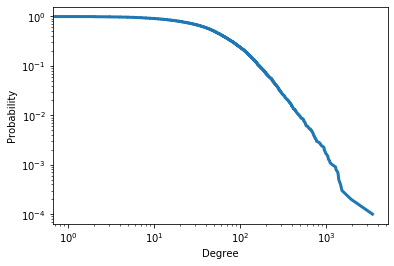

In [12]:
plt.loglog(np.sort(in_degrees), 1 - np.arange(n)/n, lw=3)
plt.xlabel('Degree')
plt.ylabel('Probability')

Text(0, 0.5, 'Probability')

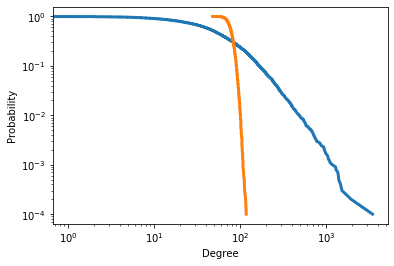

In [13]:
plt.loglog(np.sort(in_degrees), 1 - np.arange(n)/n, lw=3)
plt.loglog(np.sort(degrees_random), 1 - np.arange(n)/n, lw=3)
plt.xlabel('Degree')
plt.ylabel('Probability')

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Compare it to the function `shortest_path` of SciPy on WikiVitals.

In [14]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    # vector of nodes reached after t steps
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    change = True
    t = 0
    while change:
        t += 1
        # to be modified
        reached = adjacency.T.dot(reached) 
        # end 
        new_nodes = np.argwhere((distances == np.inf) * reached).ravel()
        distances[new_nodes] = t
        change = len(new_nodes)
    return distances

In [15]:
adjacency = openflights.adjacency > 0
distances = get_distances(adjacency, 0)
distances_scipy = shortest_path(adjacency, indices = [0])

In [16]:
np.sum(np.abs(distances - distances_scipy))

0.0

## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [22]:
adjacency = openflights.adjacency > 0
n = adjacency.shape[0]
names = openflights.names
source = 622
names[source]

'Charles de Gaulle International Airport'

In [32]:
distances_cdg = get_distances(adjacency, source)
nb_inf3 = np.argwhere(distances_cdg<=2).shape[0]
print(nb_inf3/len(distances_cdg))

0.6189861155957378


In [33]:
distances_cdg[source]

0.0

## To do

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Adapt this function so that it returns a path of length equal to this estimated diameter.
* Give a path of **length at least 10** in Openflights (with the names of the airports).
* Give a path of **length at least 5** in WikiVitals (with the names of the articles).

In [57]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter. 
    '''    
    n = adjacency.shape[0]
    nodes = np.random.choice(n, size=n_samples)
    distances = shortest_path(adjacency.T, indices=nodes)
    sources = np.where(np.isinf(distances), -1, distances).argmax(axis=1)    
    distances = shortest_path(adjacency, indices=sources)
    diameter = np.where(np.isinf(distances), -1, distances).max()
    return int(diameter)

## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors.
* Plot the corresponding histogram.

**Hint:** Use distances in the bipartite graph. Do **not** try to compute the co-starring graph of actors, with adjacency matrix $A = B^TB$ where $B$ is the movie-actor biadjacency matrix (guess why).

In [58]:
cinema.biadjacency

<88440x44586 sparse matrix of type '<class 'numpy.bool_'>'
	with 304006 stored elements in Compressed Sparse Row format>

## 3. Clustering coefficient

You will now learn to estimate the clustering coefficient of a graph.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Test it on a triangle and  a line.
* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).

**Hint:** A triangle is... a cycle of length 3

In [ ]:
def clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 500) -> float:
    '''Get the clustering coefficient of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    
    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''
    
    
    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)
    # to be modified
    # a single loop on preselected nodes allowed
    clustering_coef = 0
    
    
    return clustering_coef

In [ ]:
triangle = cyclic_graph(3)

In [ ]:
line = linear_graph(5)